# Extract housing prices in San Francisco 
- using: Zillow via Beautiful Soup & Selenium
    - ex) Reddit uses Beautifu Soup to (try to) pull a representative image from posted links
- extracting: Address, Neighborhood, Price, Zestimate, Facts and Features, Posting Traffic, Posting Interest, and Posting Age
- purpose: capture listing data for analysis

#### imports

In [98]:
import os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import sys
import numpy as np
import pandas as pd
import regex as re
import selenium
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException

#### function to alter Chrome window dimensions

In [99]:
def set_viewport_size(driver, width, height):
    window_size = driver.execute_script("""
        return [window.outerWidth - window.innerWidth + arguments[0],
          window.outerHeight - window.innerHeight + arguments[1]];
        """, width, height)
    driver.set_window_size(*window_size)

#### set up chromedriver

In [100]:
from fake_useragent import UserAgent

ua = UserAgent()
useragent = ua.random
options = webdriver.ChromeOptions()
print('--user-agent="'+str(useragent)+'"')

options.add_argument(f'user-agent={useragent}') #Path to random chrome profile
chrome_path = "c:\\bin\\chromedriver" # path to the chromedriver executable
driver = webdriver.Chrome(executable_path=chrome_path, chrome_options=options)
driver.wait=WebDriverWait(driver, 10)

set_viewport_size(driver, 800, 600) # set the viewport size to 800 x 600

--user-agent="Mozilla/5.0 (X11; CrOS i686 3912.101.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.116 Safari/537.36"


C:\Users\emag3\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':


In [144]:
def _is_element_displayed(driver, elem_text, elem_type):
    if elem_type == "class":
        try:
            out = driver.find_element_by_class_name(elem_text).is_displayed()
        except (NoSuchElementException, TimeoutException):
            out = False
    elif elem_type == "css":
        try:
            out = driver.find_element_by_css_selector(elem_text).is_displayed()
        except (NoSuchElementException, TimeoutException):
            out = False
    else:
        raise ValueError("arg 'elem_type' must be either 'class' or 'css'")
    return(out)

In [145]:
# If captcha page is displayed, this function will run indefinitely until the 
# captcha page is no longer displayed (checks for it every 30 seconds).
# Purpose of the function is to "pause" execution of the scraper until the 
# user has manually completed the captcha requirements.
def _pause_for_captcha(driver):
    while True:
        time.sleep(30)
        if not _is_element_displayed(driver, "captcha-container", "class"):
            break

In [146]:
def check_for_captcha(driver):
    if _is_element_displayed(driver, "captcha-container", "class"):
        print("\nCAPTCHA!\n"\
              "Manually complete the captcha requirements.\n"\
              "Once that's done, if the program was in the middle of scraping "\
              "(and is still running), it should resume scraping after ~30 seconds.")
        _pause_for_captcha(driver)

In [147]:
def navigate_to_website(driver, site):
    driver.get(site)
    # Check to make sure a captcha page is not displayed.
    check_for_captcha(driver)

#### checking python path

In [101]:
sys.executable

'C:\\Users\\emag3\\Anaconda3\\python.exe'

#### adding the unfiltered Zillow link for San Francisco

In [102]:
zillow_sf_url = "https://www.zillow.com/homes/San-Francisco-CA_rb/"
driver.get(zillow_sf_url)

#### extracting links for each listing

In [ ]:
soup = BeautifulSoup(driver.page_source, 'html.parser')
listings = soup.find_all("a", class_="list-card-link")
listings[:5]

#### interested in the href attribute 
- contains the actual link and the 'clickable' text that appears on the page

In [ ]:
listings[0]['href']

#### extracting the link to navigate to the next page of listings

In [ ]:
next_button = soup.find_all("li", class_="zsg-pagination-next")

print('https://www.zillow.com'+next_button[0].find('a').get('href',''))
 
print(a.find('a').get('href','') for a in next_button)

#### function returning every listing link (up to 20 pages worth)

In [55]:
def get_house_links(url, driver, pages=20):
    house_links=[]
    driver.get(url)
    for i in range(pages):
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        listings = soup.find_all("a", class_="list-card-link")
        page_data = [row['href'] for row in listings]
        house_links.append(page_data)
        time.sleep(2)
        next_button = soup.find_all("li", class_="zsg-pagination-next")
        time.sleep(2)
        if next_button[0].find('a') is not None:
            next_button_link = 'https://www.zillow.com'+next_button[0].find('a').get('href','')
        else:
            break

        if i<19:
            driver.get(next_button_link)
    
    return house_links

#### test: get_house_links

In [59]:
zillow_sf_url = "https://www.zillow.com/homes/San-Francisco-CA_rb/"
links = get_house_links(zillow_sf_url, driver)

#### function returning html 'soup' from Zillow

In [97]:
#print(str(links))
print(urls)

with open('SF Zillow house links.txt','w',encoding='utf-8') as file:
    file.write(str(urls))
    file.close()

['https://www.zillow.com/homedetails/1538-Visitacion-Ave-San-Francisco-CA-94134/15174451_zpid/', 'https://www.zillow.com/community/mira/2082609849_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-palisades/2083269123_zpid/', 'https://www.zillow.com/community/mira/2082609853_zpid/', 'https://www.zillow.com/homedetails/49-53-Guerrero-St-San-Francisco-CA-94103/2084992008_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-landing/2082903489_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-landing/2083281869_zpid/', 'https://www.zillow.com/homedetails/83-Mcallister-St-APT-204-San-Francisco-CA-94102/89240044_zpid/', 'https://www.zillow.com/community/mira/2082609854_zpid/', 'https://www.zillow.com/community/one-mission-bay/2084054918_zpid/', 'https://www.zillow.com/homedetails/355-1st-St-S-505-Aka-355-01st-St-San-Francisco-CA-94105/2081645302_zpid/', 'https://www.zillow.com/homedetails/201-Harrison-St-APT-823-San-Francisco-CA-94105/15148349_zpid/'

In [93]:
# capture every other URL from links in order to avoid duplicates
urls = []
for i in links:
    for j in i[::2]:
        urls.append(j)
        
print(urls)

['https://www.zillow.com/homedetails/1538-Visitacion-Ave-San-Francisco-CA-94134/15174451_zpid/', 'https://www.zillow.com/community/mira/2082609849_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-palisades/2083269123_zpid/', 'https://www.zillow.com/community/mira/2082609853_zpid/', 'https://www.zillow.com/homedetails/49-53-Guerrero-St-San-Francisco-CA-94103/2084992008_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-landing/2082903489_zpid/', 'https://www.zillow.com/community/san-francisco-shipyard-landing/2083281869_zpid/', 'https://www.zillow.com/homedetails/83-Mcallister-St-APT-204-San-Francisco-CA-94102/89240044_zpid/', 'https://www.zillow.com/community/mira/2082609854_zpid/', 'https://www.zillow.com/community/one-mission-bay/2084054918_zpid/', 'https://www.zillow.com/homedetails/355-1st-St-S-505-Aka-355-01st-St-San-Francisco-CA-94105/2081645302_zpid/', 'https://www.zillow.com/homedetails/201-Harrison-St-APT-823-San-Francisco-CA-94105/15148349_zpid/'

In [103]:
def get_soup(links, driver):
    all_soup = []
    for x in links:
        soup = get_html_data(x, driver)
        time.sleep(np.random.lognormal(0,1)+3)
        all_soup.append(soup)
    return all_soup
        
ult_soup = get_soup(urls, driver)

<html class="zsg-theme-modernized null fonts-stage-2" itemscope="" itemtype="http://schema.org/Organization" lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#" xmlns:product="http://ogp.me/ns/product#"><head>
<link href="//fonts.googleapis.com" rel="preconnect"/><link href="//maps.googleapis.com" rel="preconnect"/><link href="//c.go-mpulse.net" rel="preconnect"/><link href="//s.zillow.net" rel="preconnect"/><link href="//keystone-ext.develop.zillow.net" rel="preconnect"/><link href="//fonts.gstatic.com" rel="preconnect"/><link href="//www.google-analytics.com" rel="preconnect"/><link href="//sb.scorecardresearch.com" rel="preconnect"/><link crossorigin="true" href="https://www.zillow.com/graphql/" rel="preconnect"/><link crossorigin="true" href="https://mortgageapi.zillow.com" rel="preconnect"/><meta charset="utf-8"/><script async="" src="//www.googletagmanager.com/gtm.js?id=GTM-P6HT97"></script><script async="" src=
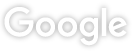

In [125]:
#625 URLs were scraped
#0 through 91 are real links, remaining items are recaptcha
print(ult_soup[91])

In [126]:
def get_html_data(url, driver):
    driver.get(url)
    time.sleep(np.random.lognormal(0,1))
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    return soup

In [28]:
with open('SF Zillow Soup.txt','w',encoding='utf-8') as file:
    file.write(str(ult_soup))
    file.close()

In [28]:
print(str(soup))

<html class="ie ie9 gte-ie9 zsg-theme-modernized null fonts-stage-2" itemscope="" itemtype="http://schema.org/Organization" lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#" xmlns:product="http://ogp.me/ns/product#"><head><link href="https://fonts.googleapis.com/css?family=Roboto:300,400,500,700|Google+Sans" rel="stylesheet" type="text/css"/>
<link href="//fonts.googleapis.com" rel="preconnect"/><link href="//maps.googleapis.com" rel="preconnect"/><link href="//c.go-mpulse.net" rel="preconnect"/><link href="//s.zillow.net" rel="preconnect"/><link href="//keystone-ext.develop.zillow.net" rel="preconnect"/><link href="//fonts.gstatic.com" rel="preconnect"/><link href="//www.google-analytics.com" rel="preconnect"/><link href="//sb.scorecardresearch.com" rel="preconnect"/><link crossorigin="true" href="https://www.zillow.com/graphql/" rel="preconnect"/><link crossorigin="true" href="https://mortgageapi.zillow.com" rel="

In [479]:
with open('SF Zillow Soup - test.txt','w',encoding='utf-8') as file:
    for url in ult_soup:
        file.write(str(url)+"XXXXX")
    file.close()

In [487]:
def get_price(soup):
    prices=[]
    for s in soup:
        #using "find" instead of "find_all" to avoid duplicate prices
        price = s.find(True, {'class':'ds-value'})
        try:
            prices.append(''.join(price.text.split()))
        except:
            prices.append(None)
    return prices

soup_test = []
with open("SF Zillow Soup - test.txt",encoding='utf-8') as f:
    text_list = list(f.read().split("XXXXX"))
    for url in text_list:
        s = BeautifulSoup(url, "html.parser")
        soup_test.append(s)
    soup_test = soup_test[:-1]   
get_price(soup_test)

['$1,250,000',
 '$1,595,000',
 '$1,195,000',
 '$2,100,000',
 '$4,695,000',
 '$880,000',
 '$1,255,000',
 '$575,000',
 '$950,000',
 '$3,700,000',
 None,
 None,
 None,
 '$1,005,000',
 '$7,375,000',
 '$4,750,000',
 '$985,000',
 '$3,700,000',
 '$1,100,000',
 '$11,495,000',
 '$900,000',
 '$1,695,000',
 '$14,000,000',
 '$2,375,000',
 '$3,715,000',
 '$1,930,000',
 '$1,890,000',
 '$699,000',
 '$1,850,000',
 '$1,105,000',
 '$1,015,000',
 '$785,000',
 '$899,000',
 '$2,500,000',
 '$1,121,000',
 '$1,193,000',
 '$1,148,000',
 '$674,000',
 '$730,000',
 '$979,000',
 '$799,000',
 '$5,495,000',
 '$1,080,000',
 '$1,475,000',
 '$1,495,000',
 '$1,095,000',
 '$1,450,000',
 '$2,188,000',
 '$541,517',
 '$11,995,000',
 '$659,900',
 '$13,750,000',
 None,
 '$1,850,000',
 '$1,288,000',
 '$1,249,000',
 None,
 '$27,500,000',
 '$2,071,000',
 '$1,995,000',
 '$5,500,000',
 '$1,650,000',
 '$1,791,000',
 '$749,900',
 '$1,098,000',
 '$3,500,000',
 '$900,000',
 '$4,375,000',
 '$899,000',
 '$3,100,000',
 '$899,888',
 '$2,1

In [476]:
type(s)

bs4.BeautifulSoup

In [477]:
type(ult_soup)

list

In [484]:
def get_zestimate(soup):
    zestimates=[]
    for listing in soup:
        ballpark = listing.find("div", {'id':'ds-home-values'})
        try:
            text = ''.join(ballpark.text.split())

            zestimate_start = text.find('$')

            zestimate_end = 0

            for char in text[zestimate_start:]:
                if char.isalpha():
                    zestimate_end = text.index(char)
                    break

            zestimates.append(text[zestimate_start:zestimate_end])
        except:
            zestimates.append(None)

    return zestimates

get_zestimate(ult_soup)

['$918,957',
 '$1,577,361',
 '$1,229,011',
 '$2,057,894',
 '$4,695,728',
 '$899,911',
 '$1,285,017',
 '$501,667',
 '$958,951',
 '$3,569,573',
 '$1.2',
 '$1.2',
 '$1.6',
 '$1,050,635',
 '$7,064,488',
 '$4,540,971',
 '$1,019,036',
 '$3,569,573',
 '$1,100,008',
 '$10,989,150',
 '$935,534',
 '$1,673,746',
 '',
 '$2,338,082',
 '',
 '$1,891,303',
 '$1,866,300',
 '$707,394',
 '$1,811,905',
 '$1,105,012',
 '$842.6',
 '$806,144',
 '$842.6',
 '$2,500,007',
 '$1,181,243',
 '$1,257,112',
 '',
 '$712,652',
 '$779,706',
 '$1,039,162',
 '$811,005',
 '$4,895,053',
 '$1,043,929',
 '$1,578,498',
 '$1,637,962',
 '$1,132,545',
 '$1,600,626',
 '$2,326,787',
 '$595,794',
 '$11,384,485',
 '$659,907',
 '$13,072,516',
 '$1.6',
 '$1,882,856',
 '$1,409,839',
 '$1,345,948',
 None,
 '$8,216,010',
 '$2,161,950',
 '$2,086,871',
 '$5,229,357',
 '$1,714,782',
 '$1,869,603',
 '$753,105',
 '$1,162,042',
 '$3,470,165',
 '$1,203,268',
 '$4,325,406',
 '$1,069,794',
 '$3,129,245',
 '$935,251',
 '$1,900,929',
 '$864,975',
 '

In [268]:
def get_beds(soup):
    beds=[]
    for listing in soup:
        living_info = listing.find_all(True, {'class':'ds-bed-bath-living-area-container'})
        try:
            bed_bath_sqft = living_info[0].find_all(True, {'class':'ds-bed-bath-living-area'},limit=3)
            num_beds = bed_bath_sqft[0].find_all('span', recursive=False)
            value = num_beds[0]
            num = ''.join(value.text.split())
            if ''.join(value.text.split()) == "--":
                num = None
            beds.append(num)
        except:
            beds.append(None)
    return beds

get_beds(ult_soup)

[None,
 '2',
 '3',
 '2',
 None,
 '2',
 '3',
 '1',
 '1',
 '3',
 None,
 None,
 None,
 '2',
 '3',
 '3',
 '2',
 '3',
 '2',
 '3',
 '2',
 '3',
 '2',
 '3',
 '2',
 '2',
 '2',
 '1',
 '6',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 None,
 None,
 '1',
 '2',
 '4',
 '5',
 '3',
 '3',
 '1',
 '3',
 '4',
 '2',
 '4',
 '1',
 '7',
 None,
 '2',
 '3',
 '4',
 None,
 '7',
 '3',
 '3',
 '6',
 '4',
 '3',
 '2',
 '2',
 '3',
 '4',
 '5',
 '2',
 '4',
 '2',
 '3',
 '2',
 '6',
 '4',
 '3',
 '3',
 '5',
 '4',
 None,
 '3',
 '3',
 '1',
 '1',
 '2',
 '2',
 '3',
 '1',
 '1',
 '2',
 '4',
 '4']

In [270]:
def get_bath(soup):
    bath=[]
    for listing in soup:
        living_info = listing.find_all(True, {'class':'ds-bed-bath-living-area-container'})
        try:
            bed_bath_sqft = living_info[0].find_all(True, {'class':'ds-bed-bath-living-area'},limit=3)
            num_bath = bed_bath_sqft[1].find_all('span', recursive=False)
            value = num_bath[0]
            num = ''.join(value.text.split())
            if ''.join(value.text.split()) == "--":
                num = None
            bath.append(num)
        except:
            bath.append(None)
    return bath

get_bath(ult_soup)

['1',
 '2',
 '3',
 '2',
 None,
 '2',
 '2',
 '1',
 '1',
 '3',
 None,
 '1',
 '2',
 '2',
 '6',
 '3',
 '2',
 '3',
 '1',
 '3',
 '2',
 '2',
 '3',
 '2',
 '3',
 '2',
 '2',
 '1',
 '3',
 '1',
 '2',
 '1',
 '2',
 '2',
 '1',
 '2',
 '1',
 '1',
 '1',
 '1',
 '2',
 '4',
 '3',
 '2',
 '2',
 '1',
 '2',
 '3',
 '1',
 '5.5',
 '1',
 '6',
 '2',
 '2.5',
 '2',
 '2',
 None,
 '11',
 '2',
 '2.5',
 '6',
 '3',
 '2',
 '2',
 '3',
 '2',
 '2',
 '6',
 '1',
 '3.5',
 '2',
 '3',
 '2',
 '3',
 '4',
 '1',
 '1',
 '2',
 '2',
 '1',
 '2',
 '3',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1.5',
 '1',
 '2',
 '5',
 '3.5']

In [274]:
def get_sqft(soup):
    sqft=[]
    for listing in soup:
        living_info = listing.find_all(True, {'class':'ds-bed-bath-living-area-container'})
        try:
            bed_bath_sqft = living_info[0].find_all(True, {'class':'ds-bed-bath-living-area'},limit=3)
            num_sqft = bed_bath_sqft[2].find_all('span', recursive=False)
            value = num_sqft[0]
            num = ''.join(value.text.split())
            if ''.join(value.text.split()) == "--":
                num = None
            sqft.append(num)
        except:
            sqft.append(None)
    return sqft

get_sqft(ult_soup)

['1,260',
 '1,293',
 '1,522',
 '1,347',
 '6,741',
 '1,020',
 '1,256',
 '412',
 '638',
 '1,976',
 None,
 '410',
 '1,500',
 '1,080',
 '3,770',
 '2,198',
 '1,080',
 '1,827',
 '947',
 '5,699',
 '1,020',
 '1,208',
 '3,199',
 '1,639',
 '1,605',
 '1,209',
 '1,234',
 '493',
 '2,500',
 '975',
 '1,080',
 '939',
 '1,190',
 '1,616',
 '846',
 '871',
 '833',
 '473',
 '431',
 '776',
 '1,219',
 '3,850',
 '1,858',
 '1,368',
 '1,885',
 '1,020',
 '1,548',
 '2,432',
 '610',
 '4,818',
 '709',
 '4,775',
 '1,500',
 '1,425',
 '1,605',
 '1,250',
 None,
 '16,000',
 '1,315',
 '2,325',
 '3,939',
 '1,525',
 '1,565',
 '1,156',
 '1,485',
 '2,067',
 '1,737',
 '5,050',
 None,
 '3,025',
 '1,263',
 '2,216',
 '881',
 '2,500',
 '3,897',
 '1,200',
 '1,748',
 '2,250',
 '3,045',
 '409',
 '1,584',
 '5,699',
 '759',
 '493',
 '895',
 '1,000',
 '1,990',
 '850',
 '530',
 '1,203',
 '4,550',
 '2,498']

In [417]:
def get_neighborhood(soup):
    neighborhood=[]
    for listing in soup:
        info = listing.find_all("div", {'class':'ds-expandable-card-section-default-padding'})
        try:
            nbhood_soup = info[2].find_all("span", {'class':'Text-sc-1vuq29o-0 iFtQDm'})
            
            possible_neighborhood = ''.join(nbhood_soup[1].text)
            if possible_neighborhood == 'San Francisco':
                possible_neighborhood = ''.join(nbhood_soup[0].text)
            
            neighborhood.append(possible_neighborhood)
        except:
            neighborhood.append(None)
    return neighborhood

get_neighborhood(ult_soup)

['Visitacion Valley',
 'Financial District',
 'Hunters Point',
 'Financial District',
 'Mint Hill',
 'Hunters Point',
 'Hunters Point',
 'Civic Center',
 'Financial District',
 'Mission Bay',
 'Rincon Hill',
 'Rincon Hill',
 'Golden Gate Heights',
 'Hunters Point',
 'Rincon Hill',
 'Financial District',
 'Hunters Point',
 'Mission Bay',
 'Financial District',
 'Rincon Hill',
 'Hunters Point',
 'Financial District',
 'South of Market',
 'Mission Bay',
 'South of Market',
 'Financial District',
 'Mission Bay',
 'Rincon Hill',
 'Parkside',
 'Financial District',
 'Hunters Point',
 'Hunters Point',
 'Hunters Point',
 'Russian Hill',
 'Dogpatch',
 'Dogpatch',
 'Mission Bay',
 'Dogpatch',
 'Dogpatch',
 'Dogpatch',
 'Bayview',
 'Eureka Valley',
 'Crocker Amazon',
 'Outer Sunset',
 'Outer Richmond',
 'Sutro Heights',
 'Stonestown',
 'Outer Richmond',
 'Noe Valley',
 'Russian Hill',
 'Telegraph Hill',
 'Presidio Heights',
 'Golden Gate Heights',
 'Lower Pacific Heights',
 'Sutro Heights',
 'Mis

In [424]:
#always in days
def get_age_of_listing(soup):
    age=[]
    for listing in soup:
        time_views_saves = listing.find_all("ul", {'class':'ds-overview-stats'})
        try:
            time_soup = time_views_saves[0].find_all("div", {'class':'ds-overview-stat-value'})
            time = ''.join(time_soup[0].text)
            time = time.split(' ', 1)[0]
            age.append(time)
        except:
            age.append(None)
    return age

get_age_of_listing(ult_soup)

['1',
 '1',
 '2',
 '2',
 '3',
 '3',
 '3',
 '4',
 '4',
 '4',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '6',
 '6',
 '6',
 '7',
 '7',
 '7',
 '7',
 '7',
 '8',
 '8',
 '8',
 '9',
 '9',
 '9',
 '9',
 '10',
 '10',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '143',
 '31',
 '97',
 '115',
 '53',
 '15',
 '80',
 '15',
 '68',
 '88',
 '134',
 '38',
 '5',
 '77',
 '141',
 '59',
 None,
 '307',
 '40',
 '21',
 '46',
 '284',
 '154',
 '129',
 '85',
 '111',
 '228',
 '67',
 '17',
 '28',
 '56',
 '41',
 '137',
 '9',
 '258',
 '214',
 '89',
 '90',
 '123',
 '124',
 '97',
 '7',
 '124',
 '9',
 '52',
 '46',
 '53',
 '58',
 '108',
 '94',
 '89',
 '24']

In [428]:
#views in last 30 days
def get_views(soup):
    views=[]
    for listing in soup:
        time_views_saves = listing.find_all("ul", {'class':'ds-overview-stats'})
        try:
            views_soup = time_views_saves[0].find_all("div", {'class':'ds-overview-stat-value'})
            view_count = ''.join(views_soup[1].text)
            #time = time.split(' ', 1)[0]
            views.append(view_count)
        except:
            views.append(None)
    return views

get_views(ult_soup)

['297',
 '164',
 '197',
 '129',
 '416',
 '251',
 '50',
 '1,434',
 '552',
 '48',
 '340',
 '412',
 '1,383',
 '19',
 '316',
 '377',
 '27',
 '88',
 '270',
 '1,080',
 '70',
 '436',
 '482',
 '164',
 '126',
 '250',
 '153',
 '1,563',
 '1,771',
 '445',
 '109',
 '315',
 '279',
 '1,420',
 '508',
 '1,334',
 '637',
 '1,071',
 '399',
 '579',
 '4,259',
 '7,311',
 '3,861',
 '4,183',
 '5,852',
 '4,062',
 '2,983',
 '5,489',
 '5,621',
 '6,626',
 '3,311',
 '5,707',
 '1,386',
 '3,962',
 '3,173',
 '3,154',
 None,
 '4,833',
 '3,563',
 '3,641',
 '4,051',
 '2,813',
 '2,483',
 '2,425',
 '3,678',
 '2,837',
 '3,190',
 '3,806',
 '4,153',
 '4,499',
 '3,096',
 '3,795',
 '2,962',
 '1,773',
 '2,457',
 '2,796',
 '2,057',
 '2,424',
 '3,156',
 '3,028',
 '2,572',
 '1,083',
 '2,080',
 '1,564',
 '3,378',
 '3,157',
 '1,979',
 '3,348',
 '2,823',
 '3,065',
 '2,467',
 '3,383']

In [431]:
#saves in last 30 days
def get_saves(soup):
    saves=[]
    for listing in soup:
        time_views_saves = listing.find_all("ul", {'class':'ds-overview-stats'})
        try:
            saves_soup = time_views_saves[0].find_all("div", {'class':'ds-overview-stat-value'})
            save_count = ''.join(saves_soup[2].text)
            #time = time.split(' ', 1)[0]
            saves.append(save_count)
        except:
            saves.append(None)
    return saves

get_saves(ult_soup)

['6',
 '6',
 '1',
 '2',
 '1',
 '1',
 '3',
 '17',
 '9',
 '1',
 '2',
 '6',
 '16',
 '0',
 '6',
 '4',
 '0',
 '0',
 '7',
 '21',
 '3',
 '12',
 '0',
 '2',
 '1',
 '4',
 '3',
 '16',
 '12',
 '5',
 '9',
 '3',
 '9',
 '11',
 '8',
 '37',
 '11',
 '18',
 '5',
 '11',
 '35',
 '132',
 '69',
 '116',
 '197',
 '64',
 '84',
 '146',
 '34',
 '178',
 '44',
 '54',
 '16',
 '78',
 '64',
 '109',
 None,
 '104',
 '32',
 '79',
 '75',
 '53',
 '79',
 '69',
 '121',
 '44',
 '23',
 '115',
 '77',
 '79',
 '57',
 '95',
 '68',
 '12',
 '58',
 '39',
 '36',
 '68',
 '53',
 '43',
 '88',
 '22',
 '66',
 '16',
 '53',
 '101',
 '29',
 '35',
 '94',
 '88',
 '50',
 '77']

In [452]:
def get_address(soup):
    addresses=[]
    for listing in soup:
        add = listing.find_all("h1", {'class':'ds-address-container'})
        try:
            address_html = add[0].find_all("span")
            address = ''.join(address_html[0].text)
            
            if 'Buildable plan: ' in address:
                address = address[16:]
            if 'Floor plan: ' in address:
                address = address[12:]
            
            addresses.append(address)
        except:
            addresses.append(None)
    return addresses

get_address(ult_soup)

['1538 Visitacion Ave,',
 '280 Spear Street #7B, MIRA,',
 'Plan A1, The San Francisco Shipyard : Palisades,',
 '280 Spear Street #14E, MIRA,',
 '49 53 Guerrero St,',
 '10 Innes Ct #304, The San Francisco Shipyard : Landing,',
 '10 Innes Ct #401, The San Francisco Shipyard : Landing,',
 '83 Mcallister St APT 204,',
 '280 Spear Street #3Q, MIRA,',
 '#1401, ONE Mission Bay,',
 '355 1st St S 505 Aka 355 01st St,',
 '201 Harrison St APT 823,',
 '2028 14th Ave,',
 '52 Innes Ct. #301, The San Francisco Shipyard : Monarch,',
 'Penthouse D36A, LUMINA,',
 '280 Spear Street #36B, MIRA,',
 '51 Innes Ct. #212, The San Francisco Shipyard : Monarch,',
 '#1302, ONE Mission Bay,',
 '280 Spear Street #2H, MIRA,',
 'Penthouse B41A, LUMINA,',
 '10 Innes Ct #403, The San Francisco Shipyard : Landing,',
 '280 Spear Street #4J, MIRA,',
 '69B, 181 Fremont,',
 '#1307, ONE Mission Bay,',
 '58C, 181 Fremont,',
 '280 Spear Street #24C, MIRA,',
 '#303, ONE Mission Bay,',
 '403 Main St APT 605N,',
 '1631 Quintara S

#### create DataFrame for analysis

In [453]:
df = pd.DataFrame(list(zip(get_address(ult_soup), get_neighborhood(ult_soup), get_beds(ult_soup), get_bath(ult_soup), 
                           get_sqft(ult_soup), get_age_of_listing(ult_soup), get_views(ult_soup), 
                           get_saves(ult_soup), get_price(ult_soup), get_zestimate(ult_soup), urls)), 
               columns =['Address', 'Neighborhood', 'Beds', 'Bathrooms', 
                         'Sqft', 'ListingAge', 'Views',
                         'Saves', 'Price', 'Zestimate','URL'])

In [454]:
pd.set_option('display.width', 5000)
df.head(20)

,Address,Neighborhood,Beds,Bathrooms,Sqft,ListingAge,Views,Saves,Price,Zestimate,URL
0,"1538 Visitacion Ave,",Visitacion Valley,None,1,"1,260",1,297,6,"$1,250,000","$918,957",https://www.zillow.com/homedetails/1538-Visita...
1,"280 Spear Street #7B, MIRA,",Financial District,2,2,"1,293",1,164,6,"$1,595,000","$1,577,361",https://www.zillow.com/community/mira/20826098...
2,"Plan A1, The San Francisco Shipyard : Palisades,",Hunters Point,3,3,"1,522",2,197,1,"$1,195,000","$1,229,011",https://www.zillow.com/community/san-francisco...
3,"280 Spear Street #14E, MIRA,",Financial District,2,2,"1,347",2,129,2,"$2,100,000","$2,057,894",https://www.zillow.com/community/mira/20826098...
4,"49 53 Guerrero St,",Mint Hill,None,None,"6,741",3,416,1,"$4,695,000","$4,695,728",https://www.zillow.com/homedetails/49-53-Guerr...
5,"10 Innes Ct #304, The San Francisco Shipyard :...",Hunters Point,2,2,"1,020",3,251,1,"$880,000","$899,911",https://www.zillow.com/community/san-francisco...
6,"10 Innes Ct #401, The San Francisco Shipyard :...",Hunters Point,3,2,"1,256",3,50,3,"$1,255,000","$1,285,017",https://www.zillow.com/community/san-francisco...
7,"83 Mcallister St APT 204,",Civic Center,1,1,412,4,"1,434",17,"$575,000","$501,667",https://www.zillow.com/homedetails/83-Mcallist...
8,"280 Spear Street #3Q, MIRA,",Financial District,1,1,638,4,552,9,"$950,000","$958,951",https://www.zillow.com/community/mira/20826098...
9,"#1401, ONE Mission Bay,",Mission Bay,3,3,"1,976",4,48,1,"$3,700,000","$3,569,573",https://www.zillow.com/community/one-mission-b...


In [462]:
df.size/11

92.0

In [463]:
df['Beds'].value_counts()

2    28
3    23
1    12
4    11
5     3
6     3
7     2
Name: Beds, dtype: int64